In [1]:
# Necessary import
from PIL import Image
import rasterio
import numpy as np
from skimage.filters import gaussian, laplace
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data loading
crops = Image.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/crops.tif')
band_01 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_01.tif').read(1))
band_02 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_02.tif').read(1))
band_03 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_03.tif').read(1))
band_04 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_04.tif').read(1))
band_05 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_05.tif').read(1))
band_06 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_06.tif').read(1))
band_07 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_07.tif').read(1))
band_08 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_08.tif').read(1))
band_09 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_09.tif').read(1))
band_10 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_10.tif').read(1))
band_11 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_11.tif').read(1))
band_12 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_12.tif').read(1))
band_13 = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_8A.tif').read(1))
edges = np.array(rasterio.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/edges.tif').read(1))

In [3]:
# Helper functions
def show_data(data, title='',clim=(0,255),colorbar=False):
    plt.figure(figsize=(18,12))
    plt.imshow(data,clim=clim)
    plt.xticks([])
    plt.yticks([])
    if colorbar==True:
        plt.colorbar()
    plt.title(title)
    plt.show()
    
def show_gray(edges,title=''):
    plt.figure(figsize=(18,12))
    plt.imshow(edges, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()
    
def normalize(f):
    lmin = float(f.min())
    lmax = float(f.max())
    return np.floor((f-lmin)/(lmax-lmin)*255.)

In [4]:
# Normalization and histogram equalization:
rows,cols = band_01.shape
channels = 13
bands = np.zeros([rows,cols,channels])
bands[...,0] = equalize_hist(normalize(band_01))
bands[...,1] = equalize_hist(normalize(band_02))
bands[...,2] = equalize_hist(normalize(band_03))
bands[...,3] = equalize_hist(normalize(band_04))
bands[...,4] = equalize_hist(normalize(band_05))
bands[...,5] = equalize_hist(normalize(band_06))
bands[...,6] = equalize_hist(normalize(band_07))
bands[...,7] = equalize_hist(normalize(band_08))
bands[...,8] = equalize_hist(normalize(band_09))
bands[...,9] = equalize_hist(normalize(band_10))
bands[...,10] = equalize_hist(normalize(band_11))
bands[...,11] = equalize_hist(normalize(band_12))
bands[...,12] = equalize_hist(normalize(band_13))

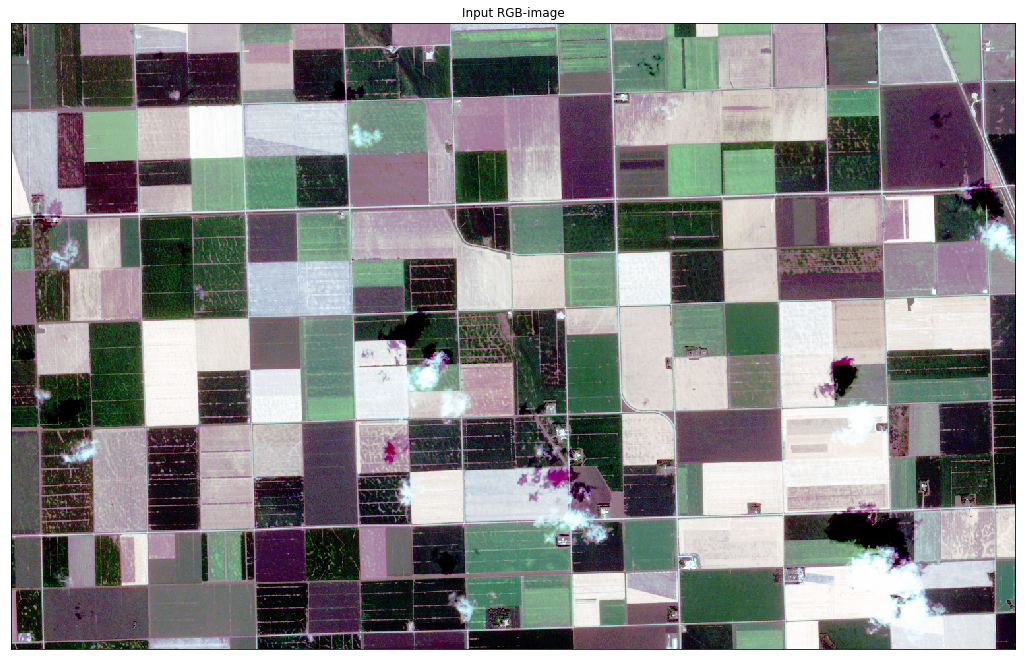

In [5]:
input_rgb = bands[...,[3,2,1]]
show_data(input_rgb, title='Input RGB-image')

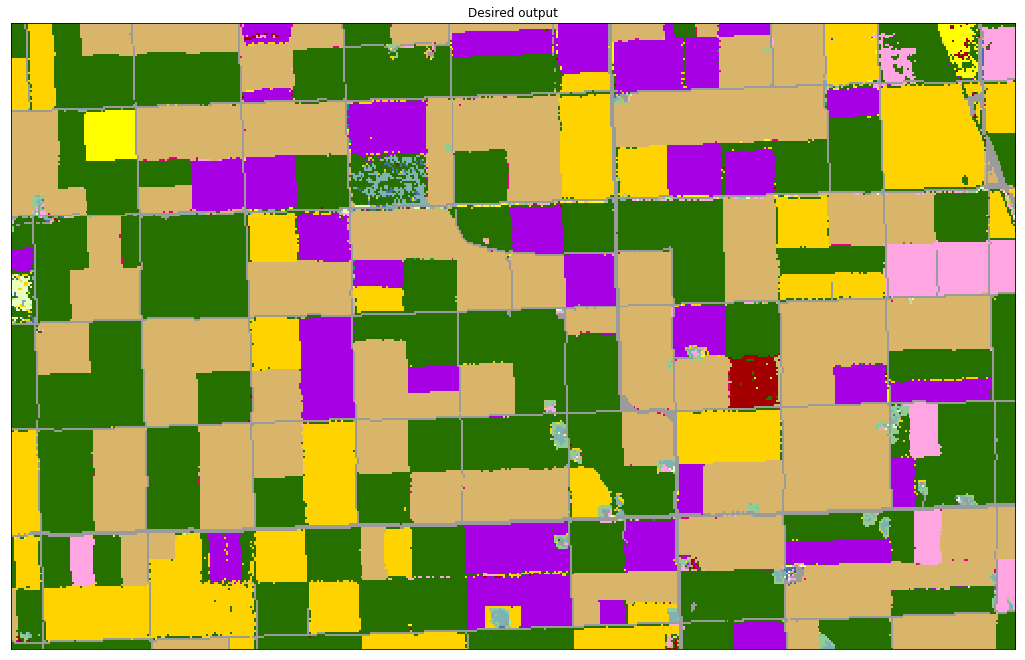

In [6]:
# show crops map: ground truth
show_data(crops, 'Desired output')

Ground truth edges

### Color-based Segmentation

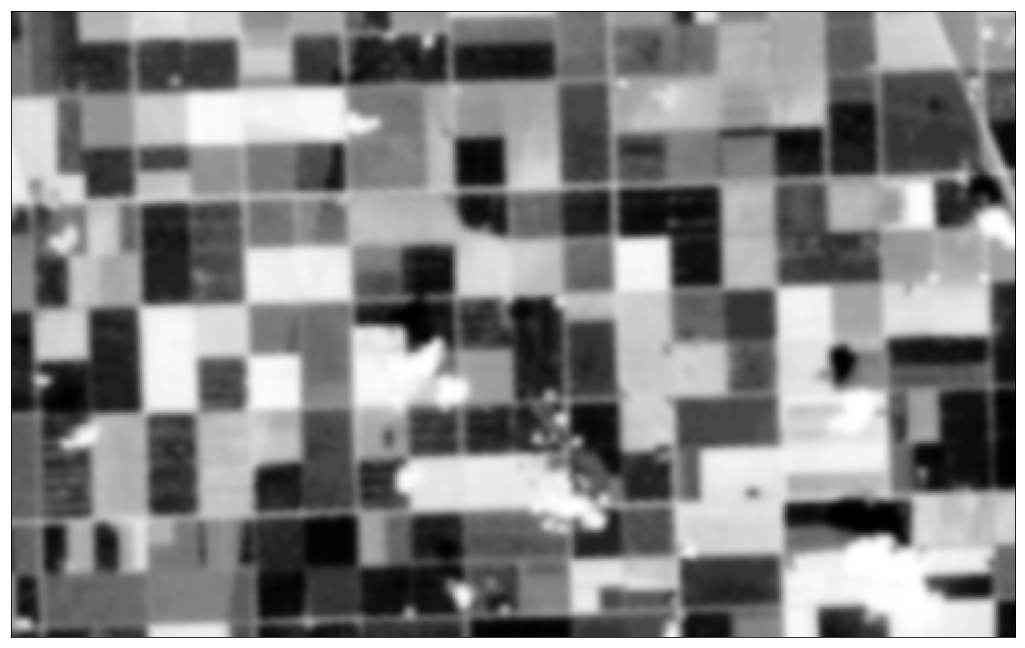

In [7]:
band = bands[...,0]
band_sm = gaussian(band,sigma=5)
show_gray(band_sm)

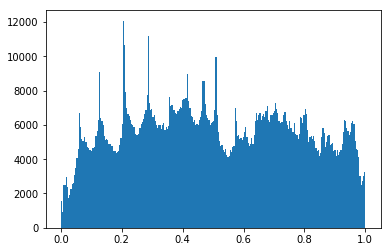

In [8]:
hist = plt.hist(band_sm.flatten(),256, range=(0,1))

Text(0.5,1,'Number of field types: 8')

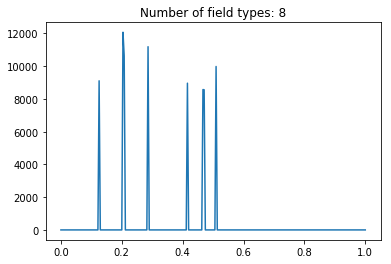

In [9]:
h = hist[0]
color = np.linspace(0,1,len(h))
hist_th = 8000 # minimum nuber of pixels to build a segment
h[h<hist_th] = 0
plt.plot(color,h)
plt.title('Number of field types: '+str(len(h[h!=0])))

In [10]:
color_of_fields = color[h!=0]
band_one_color = np.zeros([band_sm.shape[0],band_sm.shape[1],len(color_of_fields)])

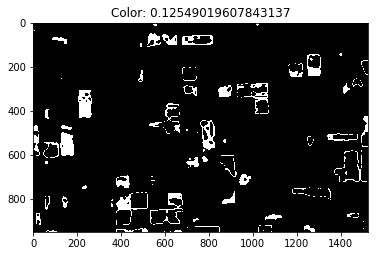

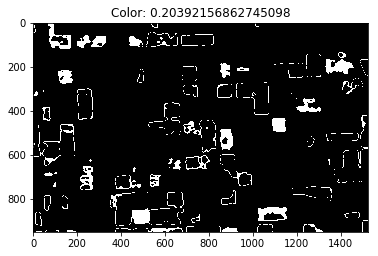

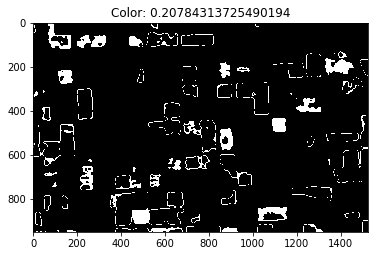

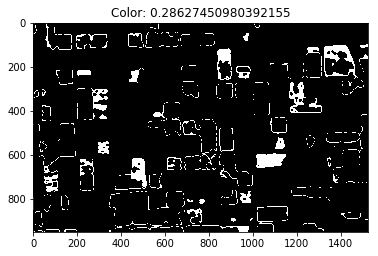

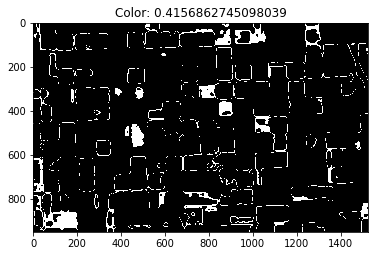

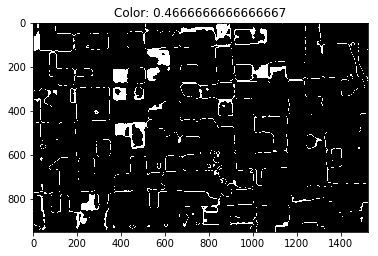

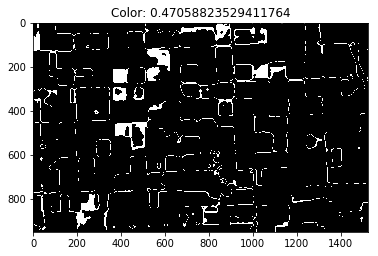

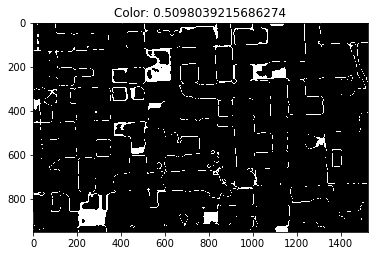

In [11]:
band_sum = np.zeros_like(band_sm)
color_range = 0.03
for c in range(len(color_of_fields)):
    # band with particular color value
    band_one_color[...,c] = np.logical_and(band_sm>=color_of_fields[c]-color_range,
                                           band_sm<=color_of_fields[c]+color_range)
    # band with all chosen colors
    band_sum = np.logical_or(band_sum,band_one_color[...,c])
    plt.imshow(band_one_color[...,c],plt.cm.gray)
    plt.title('Color: '+str(color_of_fields[c]))
    plt.show()

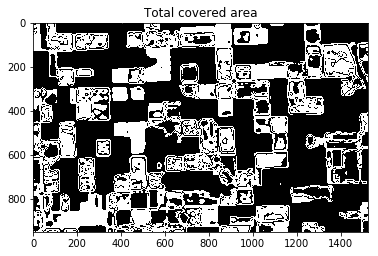

In [12]:
plt.imshow(band_sum,plt.cm.gray)
plt.title('Total covered area')
plt.show()
# balck region denotes here another type of field`

In [13]:
# Morphology for each color band
def morphband(band,Noe,Nod):
    tmp = band
    for e in range(Noe):
        eroded = binary_erosion(tmp)
        tmp = eroded

    for d in range(Nod):
        dilated = binary_dilation(eroded)
        eroded = dilated
    if Nod!=0:
        result = dilated
    else:
        result = eroded
    return result

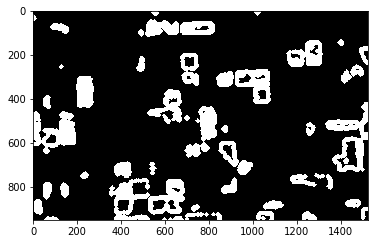

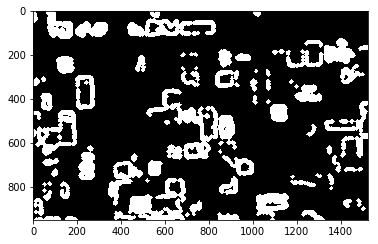

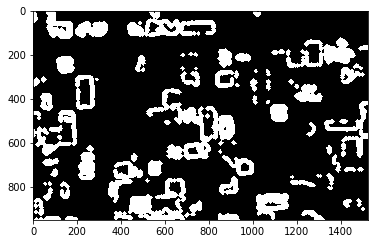

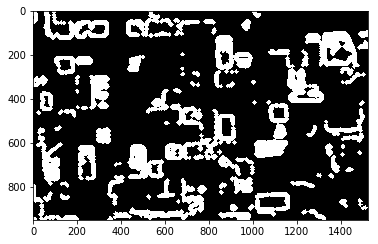

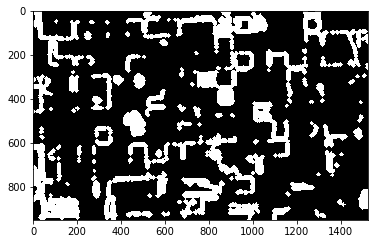

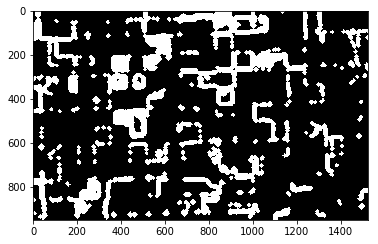

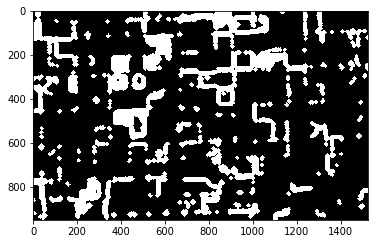

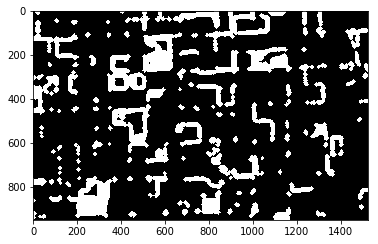

In [14]:
band_mp = np.zeros_like(band_one_color)
for c in range(len(color_of_fields)):
    band_mp[...,c] = morphband(band_one_color[...,c],Noe=1,Nod=10)
    plt.imshow(band_mp[...,c],plt.cm.gray)
    plt.show()

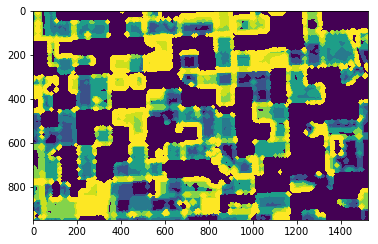

In [15]:
result = np.zeros_like(band_sm)
for c in range(len(color_of_fields)):
    result[band_mp[...,c]==1] = color_of_fields[c]

plt.imshow(result)

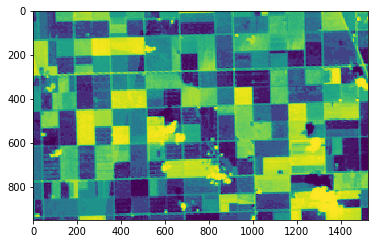

In [16]:
plt.imshow(band)

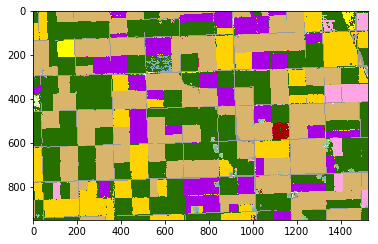

In [17]:
plt.imshow(crops)

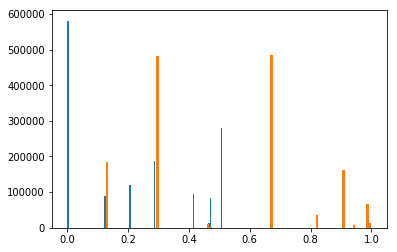

In [18]:
p1 = plt.hist(result.flatten(),100)
p2 = plt.hist(equalize_hist(normalize(np.array(crops))).flatten(),100)

Results evaluation

In [19]:
S_I = result.shape[0] * result.shape[1]
S_j = []
for j in range(int(result.max())):
    S_j.append(len(np.where(result==j+1)[0]))
p_i = np.array(S_j) / S_I
H_l = - np.sum(p_i * np.log(p_i))

In [21]:
H_r = []
pan = np.round(np.sum(band), 2)
for j in range(int(result.max())):
    r = pan[np.where(result==j+1)]
    S_j = len(r)
    p_i = np.array([len(np.where(r==i)[0])/S_j for i in set(r)])
    H_v = -np.sum(p_i*np.log(p_i))
    H_r.append(S_j*H_v/S_I)
H_r = np.sum(H_r)

In [24]:
E = H_l + H_r
print(E)

0.0


## Split and Merge algorithm

In [143]:
def split(region):
    width = region.shape[0] // 2
    height = region.shape[1] // 2
    ul = region[:width,:height]
    bl = region[width:,:height]
    ur = region[:width,height:]
    br = region[width:,height:]
    return ul,ur,bl,br

def meancolor(region):
    mean_color = np.sum(region) / ( region.shape[0]*region.shape[1] )
    return mean_color

def merge(region1,region2):
    region1_mean = ( meancolor(region1)+meancolor(region2) )/2 * np.ones_like(region1)
    region2_mean = ( meancolor(region1)+meancolor(region2) )/2 * np.ones_like(region2)
    return region1_mean, region2_mean

def ishomogenious(region,std_th):     
    return np.std(region.flatten()) < std_th

In [144]:
def isneighbour(r1,r2):
    '''
       ur ul br bl
       __________
    ur| 1  1  1  0
    ul| 1  1  0  1
    br| 1  0  1  1
    bl| 0  1  1  1
    '''
    neighbour_matrix = np.array([[1,1,1,0],
                                 [1,1,0,1],
                                 [1,0,1,1],
                                 [0,1,1,1]])
    return neighbour_matrix[r1,r2]

In [145]:
def uniteregions(r1,r2):
    if r1.shape[0]==r2.shape[0]:
        r12 = np.hstack([r1,r2])
    if r1.shape[1]==r2.shape[1]:
        r12 = np.vstack([r1,r2])
    return r12

In [147]:
# init
image = bands[...,0]
std_th = 0.3
regions = []
ul,ur,bl,br = split(image)
regions.append(ul)
regions.append(ur)
regions.append(br)
regions.append(bl)

In [148]:
region = image
for r in range(len(regions)):
    if ~ishomogenious(regions[r], std_th):
        print('spliting')
        ul,ur,bl,br = split(regions[r])
    else:
        print('merging')
        # if neighbours
        for i in range(len(regions)):
            if i!=r:
                if isneighbour(r,i):
                # and if ishomogenious(r1 U r2)
                    if ishomogenious( uniteregions(regions[r],regions[i]),std_th ):
                        # merging
                        regions[i],regions[r] = merge(regions[i],regions[r])
        up = np.hstack([regions[0],regions[1]])
        down = np.hstack([regions[2],regions[3]])
        region = np.vstack([up,down])

merging
merging
merging
merging


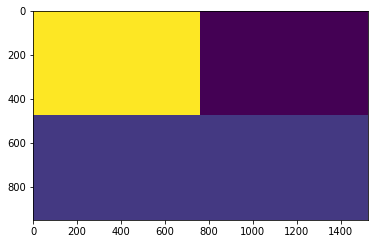

In [149]:
plt.imshow(region)

Here is a pseudocode to split and merge algorithm:

1. Init: we have only one big region (the whole image).
2. Split: If P(Ri)=TRUE proceed to next step. Otherwise subdivide Ri to four subregions and perform step 2 on them.
3. Merge: If Ri and Rj are neighbors and P(Ri U Rj) = TRUE, merge the two regions, than repeat step 3.
   If there are no such regions we are finished.


In [196]:
std_th = 0.3
roi = bands[...,0]
width = roi.shape[0] // 2
height = roi.shape[1] // 2

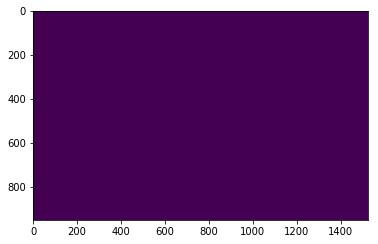

In [197]:
ul,ur,bl,br = split(roi)
if ishomogenious(ul,std_th):
    if ishomogenious( uniteregions(ul,ur),std_th ):
        roi[:width,:] = np.hstack([merge(ul,ur)[0],merge(ul,ur)[1]])
    if ishomogenious( uniteregions(ul,bl),std_th ):
        roi[:,:height] = np.vstack([merge(ul,bl)[0],merge(ul,bl)[1]])

if ishomogenious(ur,std_th):
    if ishomogenious( uniteregions(ur,br),std_th ):
        roi[:,height:] = np.vstack([merge(ur,br)[0],merge(ur,br)[1]])
        
if ishomogenious(bl,std_th):
    if ishomogenious( uniteregions(bl,br),std_th ):
        roi[width:,:] = np.hstack([merge(bl,br)[0],merge(bl,br)[1]])
        
plt.imshow(bands[...,0])